# Stage 3: Calculate Metrics and Analyze Results

This notebook:
1. Loads ground truth data and fetched results
2. Calculates accuracy metrics (F1, Precision, Recall) for keys, non-keys, and overall
3. Analyzes performance by strategy
4. Visualizes trade-offs between accuracy, efficiency, and quality
5. Examines performance across different table characteristics

## Setup and Imports

In [294]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from unidecode import unidecode
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 7)

In [295]:
# Configuration
ROOT = Path('.')
PROCESSING_ROOT = ROOT / 'processing'
BENCHMARK_ROOT = ROOT / 'benchmark_tables'
DATA_DIR = PROCESSING_ROOT / '0_data'
FETCHING_DIR = PROCESSING_ROOT / '2_fetching'
OUTPUT_DIR = PROCESSING_ROOT / '3_metrics'

# Find latest directories
data_subdirs = sorted([d for d in DATA_DIR.iterdir() if d.is_dir()], reverse=True)
fetching_subdirs = sorted([d for d in FETCHING_DIR.iterdir() if d.is_dir()], reverse=True)

if not data_subdirs:
    raise FileNotFoundError(f"No data found in {DATA_DIR}")
if not fetching_subdirs:
    raise FileNotFoundError(f"No fetching results found in {FETCHING_DIR}")

LATEST_DATA_DIR = data_subdirs[0]
LATEST_FETCHING_DIR = fetching_subdirs[0]

print(f'Data directory: {LATEST_DATA_DIR}')
print(f'Fetching directory: {LATEST_FETCHING_DIR}')
# LATEST_FETCHING_DIR = 'processing/2_fetching/20251005_014416'

# Create output directory
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = OUTPUT_DIR / timestamp
output_dir.mkdir(parents=True, exist_ok=True)
print(f'Output directory: {output_dir}')

Data directory: processing/0_data/20251004_213355
Fetching directory: processing/2_fetching/20251005_024414 copy
Output directory: processing/3_metrics/20251005_091149


## Accuracy Evaluation Functions

These functions are adapted from `X101_Calculate_Metrics.ipynb` to evaluate table accuracy.

In [296]:
def normalize_value(value, is_date=False):
    """Normalize a cell value for comparison."""
    if value != value:  # NaN check
        return ''

    if is_date:
        try:
            return pd.to_datetime(value)
        except:
            pass
        
    if type(value).__module__ == 'numpy':
        value = value.item()

    if isinstance(value, str):
        # Handle numeric strings
        if value.startswith('-') and value.replace('-', '').replace(',', '').isdigit():
            return int(value.replace(',', ''))
        if value.replace(',', '').isdigit():
            return int(value.replace(',', ''))
        if value.startswith('=') and value[1:].isdigit():
            return int(value.replace('=', ''))
        if value.startswith('-') and value.replace('-', '').replace(',', '').replace('.', '').isdigit():
            return float(value.replace(',', ''))
        if value.replace(',', '').replace('.', '').isdigit():
            return float(value.replace(',', ''))
        
        value = value.strip().lower()

        if value in ('none', 'n/a', 'nan', '-'):
            return ''

        value = value.replace('&', 'and')

        if value == 'united states':
            return 'usa'
        if value == 'united kingdom':
            return 'uk'
        
        value = unidecode(value)
        value = ''.join(c for c in value if c.isalnum())
        return value

    return value


def normalize_key(value, is_date=False):
    """Normalize a key column value for matching."""
    if value != value:  # NaN check
        return ''

    if is_date:
        try:
            return str(pd.to_datetime(value))
        except:
            pass

    if isinstance(value, str):
        value = value.strip().lower()

        if value in ('none', 'n/a', 'nan', '-', '--', 'unknown'):
            return ''

        value = value.replace('&', 'and')

        if value == 'united states':
            return 'usa'
        if value == 'united kingdom':
            return 'uk'

        value = unidecode(value)
        value = ''.join(c for c in value if c.isalnum())
        return value

    return str(value)


def normalize_primary_columns(df, norm_columns, date_columns, primary_columns, keys_type):
    """Normalize primary key columns and return list of key tuples."""
    df = df.copy()
    
    for col in norm_columns:
        df[col] = df[col].apply(lambda x: normalize_key(x, col in date_columns))
    
    for col, key_type in zip(primary_columns, keys_type):
        if key_type == 'year':
            df[col] = df[col].astype(float).astype(int)
        df[col] = df[col].astype(str)
    
    return [tuple(r) for r in df[primary_columns].to_numpy()]


def find_row(df, columns, values):
    """Find a row in dataframe by key column values."""
    query = ' & '.join([f'(`{col}`=="{value}")' for col, value in zip(columns, values)])
    return df.query(query)


def evaluate_table(df_fetched, df_ref, primary_columns, keys_type, date_columns, epsilons):
    """
    Evaluate fetched table against reference table.
    
    Returns tuple of:
    - keys_recall, keys_precision, keys_f1_score
    - non_keys_recall, non_keys_precision, non_keys_f1_score
    - recall, precision, f1_score
    - relative_non_key_accuracy
    """
    columns = df_ref.columns
    
    # Ensure fetched table has same columns as reference
    df_fetched = df_fetched[columns].copy()
    df_ref = df_ref.copy()
    df_fetched = df_fetched.drop_duplicates(subset=primary_columns)
    
    # Remove rows with missing primary keys
    for pc in primary_columns:
        df_fetched = df_fetched[df_fetched[pc].notna()]
    
    # Normalize primary key columns IN THE DATAFRAMES
    # This modifies the dataframes so find_row() can work correctly
    norm_columns = set(primary_columns)
    
    for col in norm_columns:
        df_fetched[col] = df_fetched[col].apply(lambda x: normalize_key(x, col in date_columns))
        df_ref[col] = df_ref[col].apply(lambda x: normalize_key(x, col in date_columns))
    
    for col, key_type in zip(primary_columns, keys_type):
        if key_type == 'year':
            df_fetched[col] = df_fetched[col].astype(float).astype(int)
            df_ref[col] = df_ref[col].astype(float).astype(int)
        df_fetched[col] = df_fetched[col].astype(str)
        df_ref[col] = df_ref[col].astype(str)
    
    # Extract entities for matching
    fetched_entities = [tuple(r) for r in df_fetched[primary_columns].to_numpy()]
    ref_entities = [tuple(r) for r in df_ref[primary_columns].to_numpy()]
    
    total_matches = 0
    key_matches = 0
    
    for fetched_entity in fetched_entities:
        if fetched_entity in ref_entities:
            row_fetched = find_row(df_fetched, primary_columns, fetched_entity)
            row_ref = find_row(df_ref, primary_columns, fetched_entity)
            key_matches += 1
            
            for column in columns:
                try:
                    value_fetched = row_fetched[column].values[0]
                    value_ref = row_ref[column].values[0]
                    
                    norm_value_fetched = normalize_value(value_fetched, column in date_columns)
                    norm_value_ref = normalize_value(value_ref, column in date_columns)
                    
                    # Check for exact match first
                    if norm_value_fetched == norm_value_ref:
                        total_matches += 1
                    # For epsilon columns, try numeric comparison with tolerance
                    elif column in epsilons and norm_value_ref != '' and norm_value_fetched != '':
                        try:
                            # Convert both to float for numeric comparison
                            fv = float(norm_value_fetched)
                            rv = float(norm_value_ref)
                            # Allow 0.1% tolerance
                            if abs(fv - rv) <= abs(rv * 0.001):
                                total_matches += 1
                        except (ValueError, TypeError):
                            # If conversion fails, they don't match
                            pass
                except Exception as e:
                    # Silently skip errors in individual cell comparisons
                    pass
    
    # Calculate overall metrics
    recall = total_matches / (df_ref.shape[0] * df_ref.shape[1]) if df_ref.shape[0] > 0 else 0.0
    precision = total_matches / (df_fetched.shape[0] * df_fetched.shape[1]) if df_fetched.shape[0] > 0 else 0.0
    f1_score = 2 * recall * precision / (recall + precision) if (recall + precision) > 0 else 0.0
    
    # Calculate key metrics
    keys_recall = key_matches / len(ref_entities) if len(ref_entities) > 0 else 0.0
    keys_precision = key_matches / len(fetched_entities) if len(fetched_entities) > 0 else 0.0
    keys_f1_score = 2 * keys_recall * keys_precision / (keys_recall + keys_precision) if (keys_recall + keys_precision) > 0 else 0.0
    
    # Calculate non-key metrics
    nk = len(primary_columns)
    non_keys_recall = (total_matches - key_matches * nk) / (df_ref.shape[0] * (df_ref.shape[1] - nk)) if df_ref.shape[0] > 0 and df_ref.shape[1] > nk else 0.0
    non_keys_precision = (total_matches - key_matches * nk) / (df_fetched.shape[0] * (df_fetched.shape[1] - nk)) if df_fetched.shape[0] > 0 and df_fetched.shape[1] > nk else 0.0
    non_keys_f1_score = 2 * non_keys_recall * non_keys_precision / (non_keys_recall + non_keys_precision) if (non_keys_recall + non_keys_precision) > 0 else 0.0
    
    relative_non_key_accuracy = (total_matches - key_matches * nk) / (key_matches * (df_ref.shape[1] - nk)) if key_matches > 0 and df_ref.shape[1] > nk else 0.0
    
    return (keys_recall, keys_precision, keys_f1_score,
            non_keys_recall, non_keys_precision, non_keys_f1_score,
            recall, precision, f1_score,
            relative_non_key_accuracy)


## Load Data and Calculate Accuracy Metrics

In [297]:
# Load metadata for all tables
metadata = {}
for json_file in LATEST_DATA_DIR.glob('*.json'):
    table_id = json_file.stem
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        # Extract metadata from 'meta' key
        metadata[table_id] = data['meta'] if 'meta' in data else data

print(f'Loaded metadata for {len(metadata)} tables')

Loaded metadata for 48 tables


In [298]:
# Evaluate accuracy for all strategy-table combinations
import traceback

results = []

strategies = ['full_table', 'row_by_row', 'attribute_based', 'classic_pagination', 'range_based']

for strategy in strategies:
    strategy_dir = LATEST_FETCHING_DIR / strategy
    if not strategy_dir.exists():
        continue
    
    csv_files = list(strategy_dir.glob('*.csv'))
    print(f"\n{'='*70}")
    print(f"Evaluating {strategy.upper()}: {len(csv_files)} tables")
    print(f"{'='*70}")
    
    for csv_file in csv_files:
        table_id = csv_file.stem
        
        if table_id not in metadata:
            print(f"  ⚠ Skipping {table_id}: metadata not found")
            continue
        
        md = metadata[table_id]
        
        try:
            # Load fetched and ground truth tables
            df_fetched = pd.read_csv(csv_file)
            df_ref = pd.read_csv(LATEST_DATA_DIR / f"{table_id}.csv")
            
            # Load execution metadata
            json_file = strategy_dir / f"{table_id}.json"
            with open(json_file, 'r', encoding='utf-8') as f:
                exec_meta = json.load(f)['execution_metadata']
            
            # Extract metadata
            primary_columns = md['keys']
            keys_type = md['keys_type']
            date_columns = md.get('dateColumns', [])
            epsilons = md.get('epsilons', [])
            
            # Calculate accuracy
            kr, kp, kf1, nkr, nkp, nkf1, r, p, f1, rnka = evaluate_table(
                df_fetched, df_ref, primary_columns, keys_type, date_columns, epsilons
            )
            
            # Combine with execution metrics
            result = {
                'table_id': table_id,
                'table_name': md['name'],
                'strategy': strategy,
                'num_rows': md['numDataRows'],
                'num_cols': md['numCols'],
                'num_cells': md['numCells'],
                
                # Accuracy metrics
                'keys_recall': kr,
                'keys_precision': kp,
                'keys_f1': kf1,
                'non_keys_recall': nkr,
                'non_keys_precision': nkp,
                'non_keys_f1': nkf1,
                'recall': r,
                'precision': p,
                'f1_score': f1,
                'relative_non_key_accuracy': rnka,
                
                # Performance metrics
                'total_pages': exec_meta['total_pages'],
                'total_tokens': exec_meta['total_tokens'],
                'total_latency': exec_meta['total_latency'],
                'avg_latency': exec_meta['avg_latency'],
                'error_rate': exec_meta['error_rate'],
                'duplicate_rows': exec_meta['duplicate_rows'],
                'columns_consistent': exec_meta['columns_consistent'],
                
                # Efficiency metrics
                'tokens_per_row': exec_meta['total_tokens'] / exec_meta['total_rows_fetched'] if exec_meta['total_rows_fetched'] > 0 else 0,
                'latency_per_row': exec_meta['total_latency'] / exec_meta['total_rows_fetched'] if exec_meta['total_rows_fetched'] > 0 else 0,
                'rows_fetched': exec_meta['total_rows_fetched']
            }
            
            results.append(result)
            print(f"  ✓ {table_id}: F1={f1:.4f}, Keys_F1={kf1:.4f}, Tokens={exec_meta['total_tokens']}")
            
        except Exception as e:
            print(f"  ✗ {table_id}: Error - {e}")
            print(f"     {traceback.format_exc()}")
            continue

# Create results dataframe
df_results = pd.DataFrame(results)
print(f"\n{'='*70}")
print(f"Evaluated {len(df_results)} strategy-table combinations")
print(f"{'='*70}")


Evaluating FULL_TABLE: 30 tables
  ✓ 39_uk_demographics_1960_2012: F1=0.1279, Keys_F1=1.0000, Tokens=6971
  ✓ 53_metropolitan_opera_us_premieres: F1=0.0952, Keys_F1=0.1176, Tokens=3374
  ✓ 31_udaykumar_films: F1=0.0316, Keys_F1=0.0526, Tokens=1927
  ✓ 19_living_proof_the_farewell_tour: F1=0.0000, Keys_F1=0.0000, Tokens=3816
  ✓ 31_udaykumar_films: F1=0.0316, Keys_F1=0.0526, Tokens=1927
  ✓ 19_living_proof_the_farewell_tour: F1=0.0000, Keys_F1=0.0000, Tokens=3816
  ✓ 40_fukushima_plant_operating_history_1970_2009: F1=0.1429, Keys_F1=1.0000, Tokens=5556  ✓ 40_fukushima_plant_operating_history_1970_2009: F1=0.1429, Keys_F1=1.0000, Tokens=5556
  ✓ 54_kasparov_kramnik_1993_2004: F1=0.1926, Keys_F1=0.6757, Tokens=2587
  ✓ 22_usa_demographics_1935_2010: F1=0.2339, Keys_F1=1.0000, Tokens=10399

  ✓ 54_kasparov_kramnik_1993_2004: F1=0.1926, Keys_F1=0.6757, Tokens=2587
  ✓ 22_usa_demographics_1935_2010: F1=0.2339, Keys_F1=1.0000, Tokens=10399
  ✓ 23_andorra_demographics_1948_2012: F1=0.1288, Ke

In [299]:
# Save detailed results
results_file = output_dir / 'detailed_results.csv'
df_results.to_csv(results_file, index=False)
print(f'Saved detailed results to {results_file}')

# Display summary statistics
print(f"\nDataFrame shape: {df_results.shape}")
print(f"Columns: {list(df_results.columns)}")
if len(df_results) > 0:
    print(f"Strategies found: {df_results['strategy'].unique()}")
    df_results.head()
else:
    print("⚠ DataFrame is empty!")

Saved detailed results to processing/3_metrics/20251005_091149/detailed_results.csv

DataFrame shape: (144, 26)
Columns: ['table_id', 'table_name', 'strategy', 'num_rows', 'num_cols', 'num_cells', 'keys_recall', 'keys_precision', 'keys_f1', 'non_keys_recall', 'non_keys_precision', 'non_keys_f1', 'recall', 'precision', 'f1_score', 'relative_non_key_accuracy', 'total_pages', 'total_tokens', 'total_latency', 'avg_latency', 'error_rate', 'duplicate_rows', 'columns_consistent', 'tokens_per_row', 'latency_per_row', 'rows_fetched']
Strategies found: ['full_table' 'row_by_row' 'attribute_based' 'classic_pagination'
 'range_based']


## Summary Statistics by Strategy

In [301]:
# Calculate summary statistics per strategy
if len(df_results) == 0:
    print("⚠ No results to summarize!")
else:
    summary_cols = ['f1_score', 'keys_f1', 'non_keys_f1', 'total_tokens', 'total_latency', 
                    'error_rate', 'duplicate_rows', 'tokens_per_row', 'latency_per_row']

    summary_stats = df_results.groupby('strategy')[summary_cols].agg(['mean', 'std', 'min', 'max'])
    summary_stats = summary_stats.round(4)

    # Save summary
    summary_file = output_dir / 'strategy_summary.csv'
    summary_stats.to_csv(summary_file)
    print(f'Saved strategy summary to {summary_file}')

    display(summary_stats)

Saved strategy summary to processing/3_metrics/20251005_091149/strategy_summary.csv


Saved strategy summary to processing/3_metrics/20251005_091149/strategy_summary.csv


f1_score                         keys_f1                  \
                       mean     std     min     max    mean     std     min   
strategy                                                                      
attribute_based      0.1256  0.1268  0.0079  0.4615  0.3876  0.3400  0.0183   
classic_pagination   0.1304  0.1033  0.0024  0.3490  0.4785  0.3726  0.0056   
full_table           0.1373  0.1307  0.0000  0.4388  0.4688  0.3983  0.0000   
range_based          0.1657  0.1408  0.0000  0.4444  0.5472  0.3924  0.0000   
row_by_row           0.1504  0.1430  0.0000  0.4956  0.4770  0.4174  0.0000   

                        non_keys_f1          ... duplicate_rows      \
                    max        mean     std  ...            min max   
strategy                                     ...                      
attribute_based     1.0      0.0684  0.0910  ...              0   0   
classic_pagination  1.0      0.0657  0.0776  ...              0  26   
full_table          1.0      0.0686  0.0889  ...              0   0   
range_based         1.0      0.0919  0.1207  ...              0   0   
row_by_row          1.0      0.0843  0.1073  ...              0   4   

                   tokens_per_row                                   \
                             mean        std       min         max   
strategy                                                             
attribute_based         1234.3847  1173.7433   70.0000   5596.5455   
classic_pagination       401.9382   260.8152  171.8100   1304.0444   
full_table               105.8019    53.6113   32.2381    223.5000   
range_based              892.3116  2984.2679   64.0673  16661.5000   
row_by_row              1420.6706   643.3494  376.5000   2936.1667   

                   latency_per_row                            
                              mean      std     min      max  
strategy                                                      
attribute_based             5.9800   6.0393  0.3468  29.3923  
classic_pagination          1.9222   1.3080  0.7095   5.4917  
full_table                  0.4681   0.2752  0.1236   1.0698  
range_based                 4.2791  14.2026  0.2529  79.2820  
row_by_row                  6.8247   3.2591  1.6421  14.3702  

[5 rows x 36 columns]

## Section 1: Accuracy Analysis

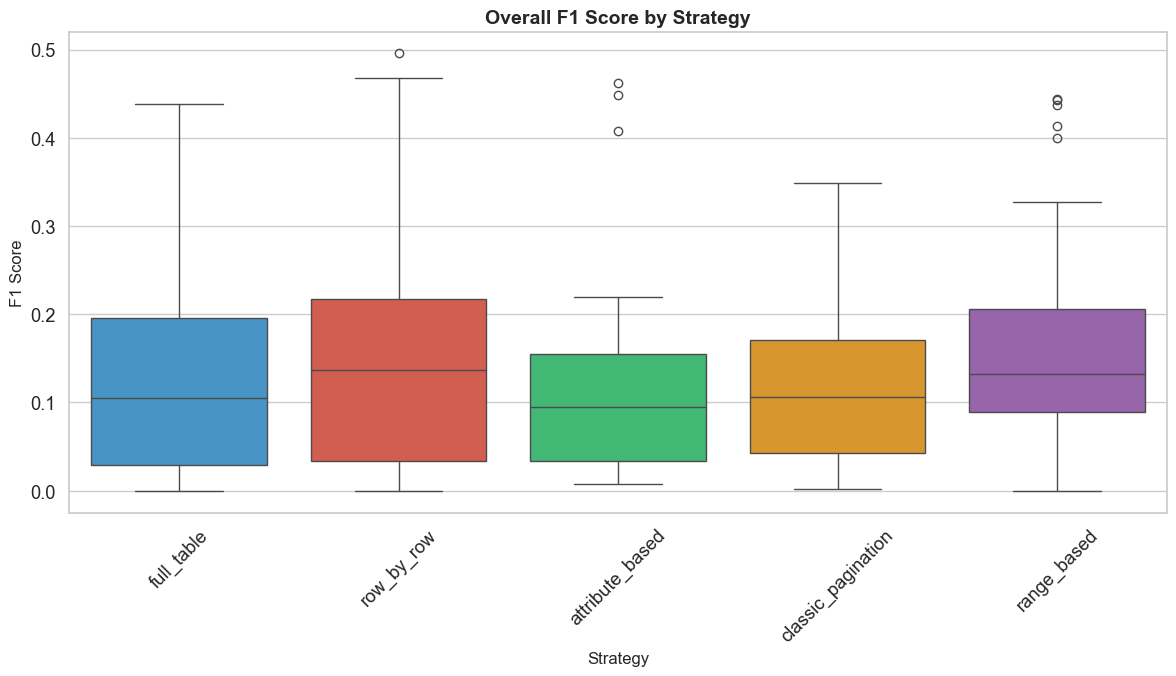

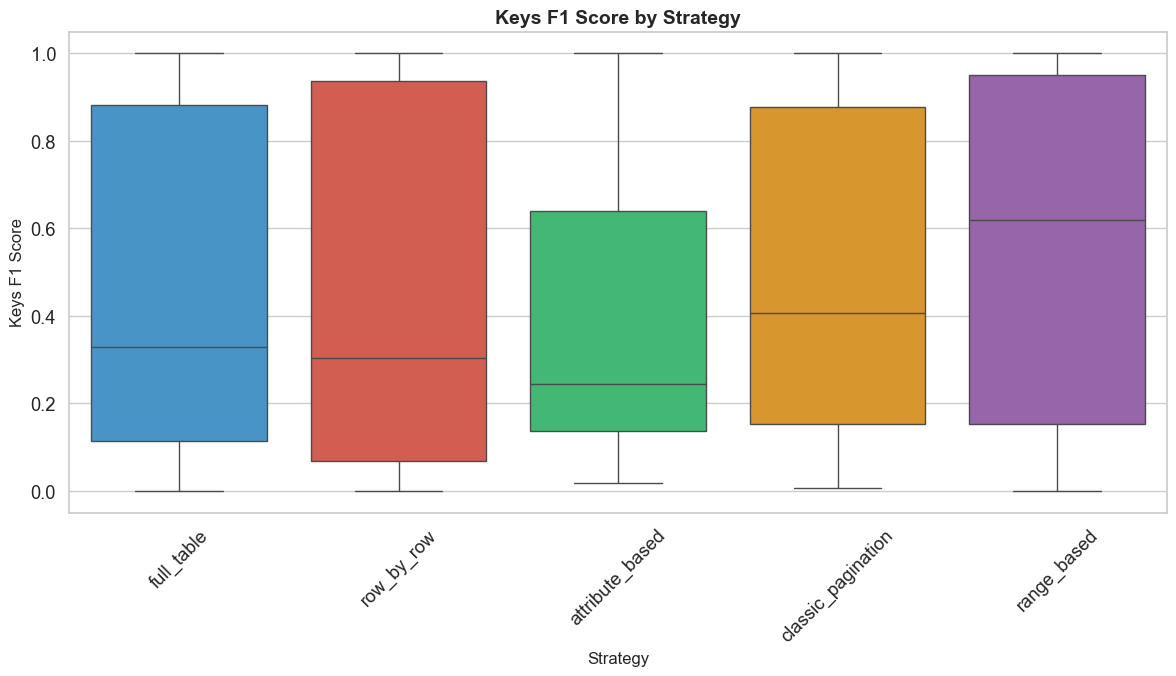

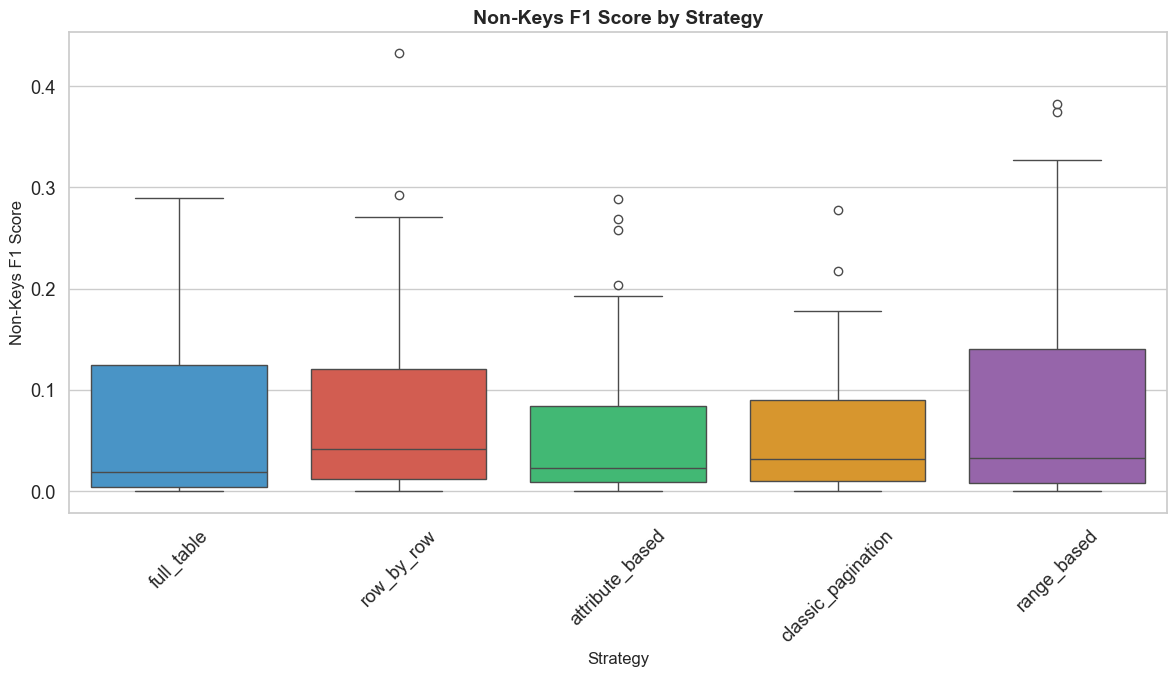

In [331]:
# Plot F1 Score by Strategy
if len(df_results) == 0:
    print("⚠ Cannot plot: No results available")
else:
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    # Overall F1
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_results, x='strategy', y='f1_score', palette=colors)
    plt.title('Overall F1 Score by Strategy', fontsize=14, fontweight='bold')
    plt.xlabel('Strategy', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_dir / 'overall_f1_by_strategy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Keys F1
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_results, x='strategy', y='keys_f1', palette=colors)
    plt.title('Keys F1 Score by Strategy', fontsize=14, fontweight='bold')
    plt.xlabel('Strategy', fontsize=12)
    plt.ylabel('Keys F1 Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_dir / 'keys_f1_by_strategy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Non-Keys F1
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_results, x='strategy', y='non_keys_f1', palette=colors)
    plt.title('Non-Keys F1 Score by Strategy', fontsize=14, fontweight='bold')
    plt.xlabel('Strategy', fontsize=12)
    plt.ylabel('Non-Keys F1 Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_dir / 'non_keys_f1_by_strategy.png', dpi=300, bbox_inches='tight')
    plt.show()

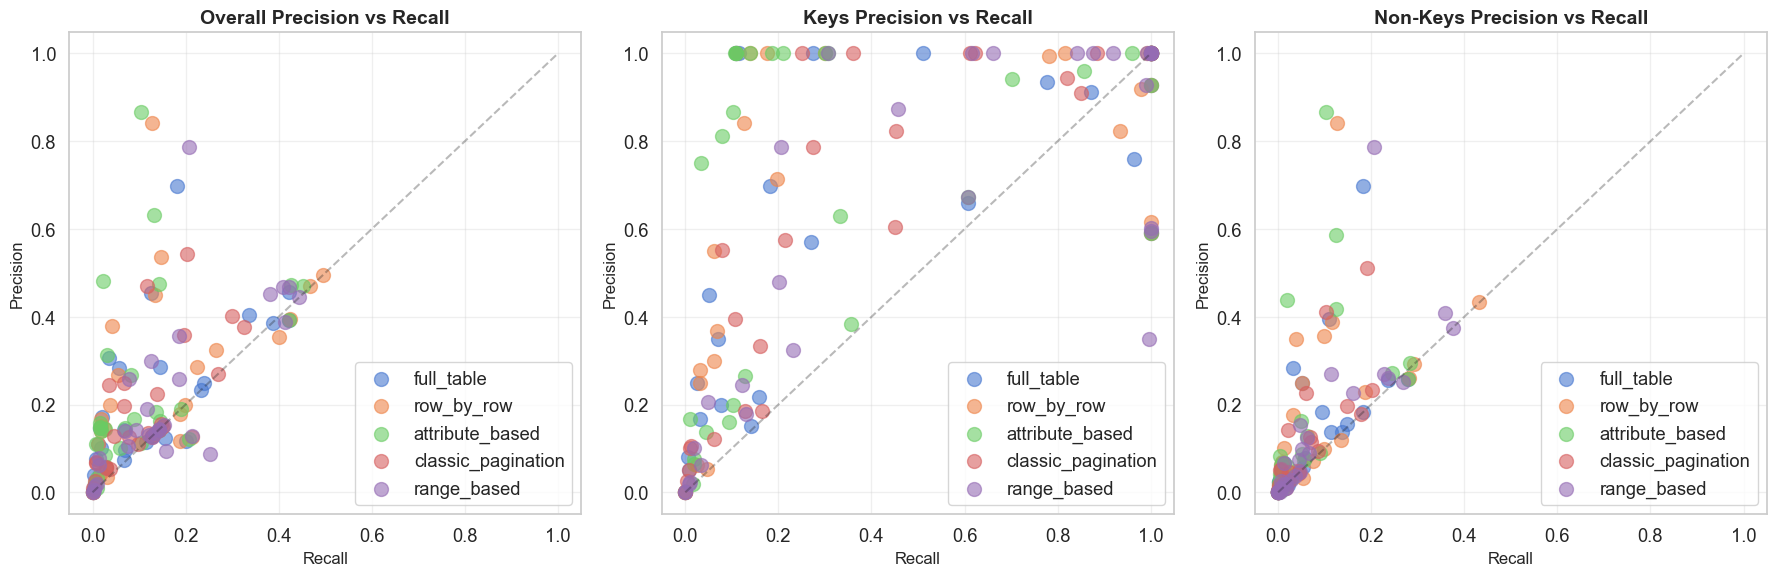

In [325]:
# Precision vs Recall by Strategy
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (metric, title) in enumerate([('Overall', 'Overall'), ('keys', 'Keys'), ('non_keys', 'Non-Keys')]):
    recall_col = f'{metric}_recall' if metric != 'Overall' else 'recall'
    precision_col = f'{metric}_precision' if metric != 'Overall' else 'precision'
    
    for strategy in df_results['strategy'].unique():
        strategy_data = df_results[df_results['strategy'] == strategy]
        axes[idx].scatter(strategy_data[recall_col], strategy_data[precision_col], 
                         label=strategy, alpha=0.6, s=100)
    
    axes[idx].set_title(f'{title} Precision vs Recall', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Recall', fontsize=12)
    axes[idx].set_ylabel('Precision', fontsize=12)
    axes[idx].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 2: Performance Analysis

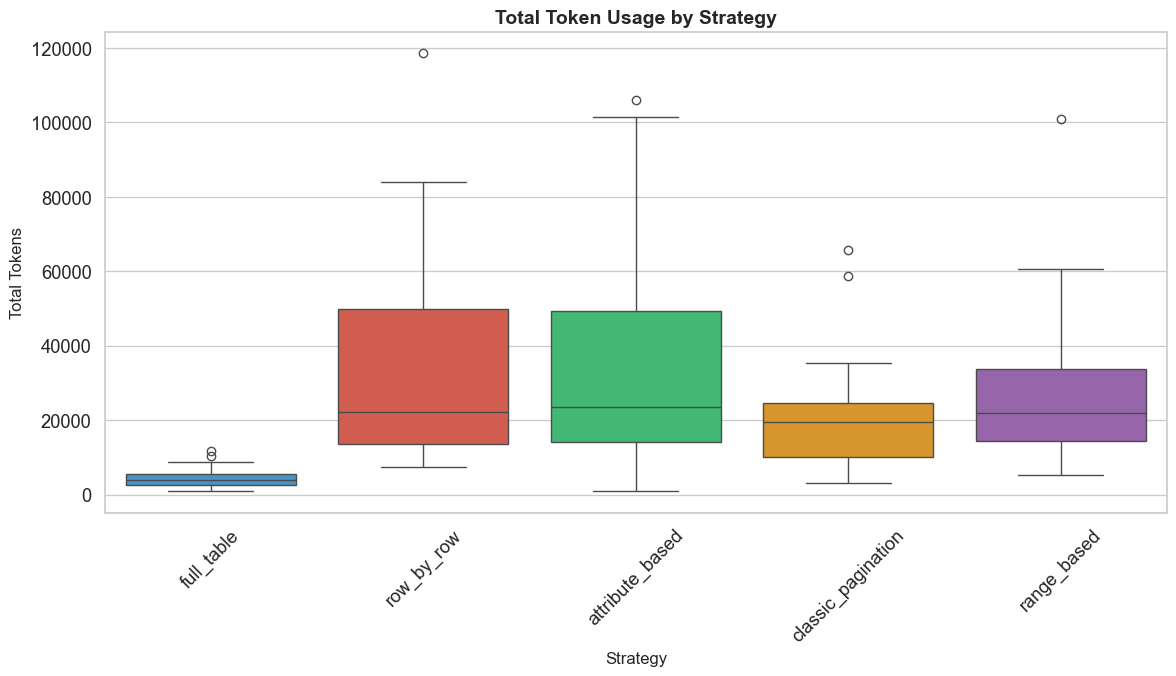

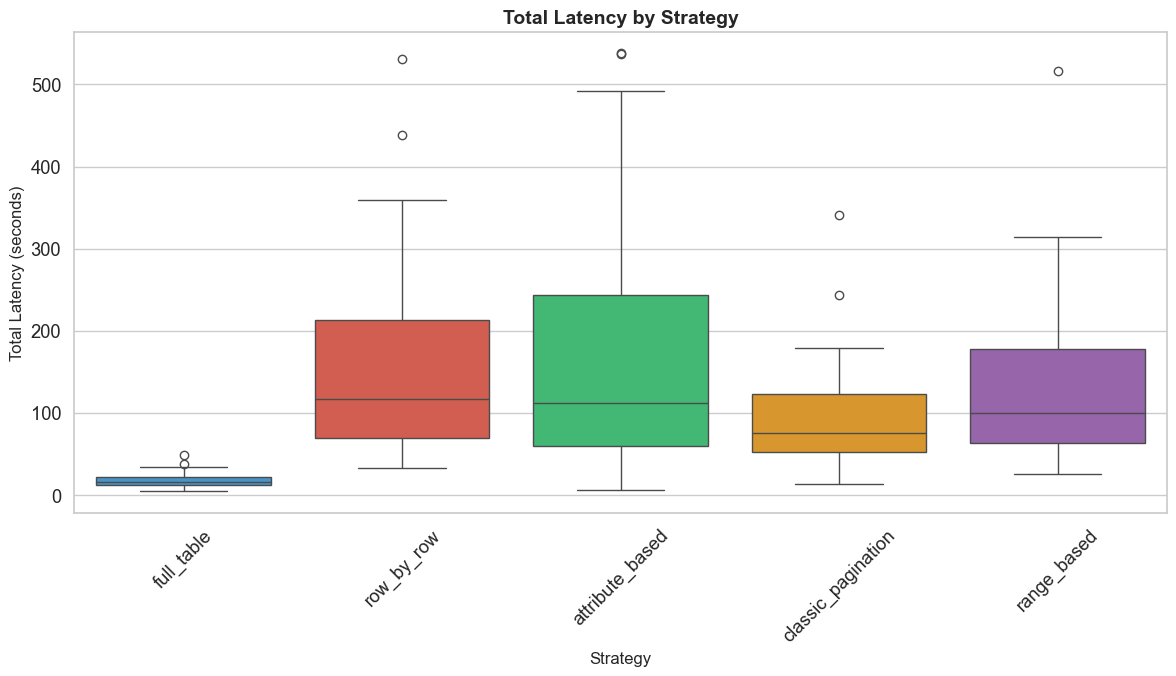

Removed 12 extreme outliers for better visualization


In [339]:
# Token Usage and Latency by Strategy
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Remove extreme outliers using IQR method
def remove_outliers(df, column, factor=3.0):
    """Remove outliers beyond factor * IQR from the quartiles"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Filter data to remove extreme outliers
df_filtered = df_results.copy()
df_filtered = remove_outliers(df_filtered, 'total_tokens', factor=3.0)
df_filtered = remove_outliers(df_filtered, 'total_latency', factor=3.0)

# Token usage
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_filtered, x='strategy', y='total_tokens', palette=colors)
plt.title('Total Token Usage by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Total Tokens', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'total_tokens_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

# Latency
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_filtered, x='strategy', y='total_latency', palette=colors)
plt.title('Total Latency by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Total Latency (seconds)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'total_latency_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print how many outliers were removed
n_removed = len(df_results) - len(df_filtered)
print(f"Removed {n_removed} extreme outliers for better visualization")

## Section 3: Efficiency Metrics

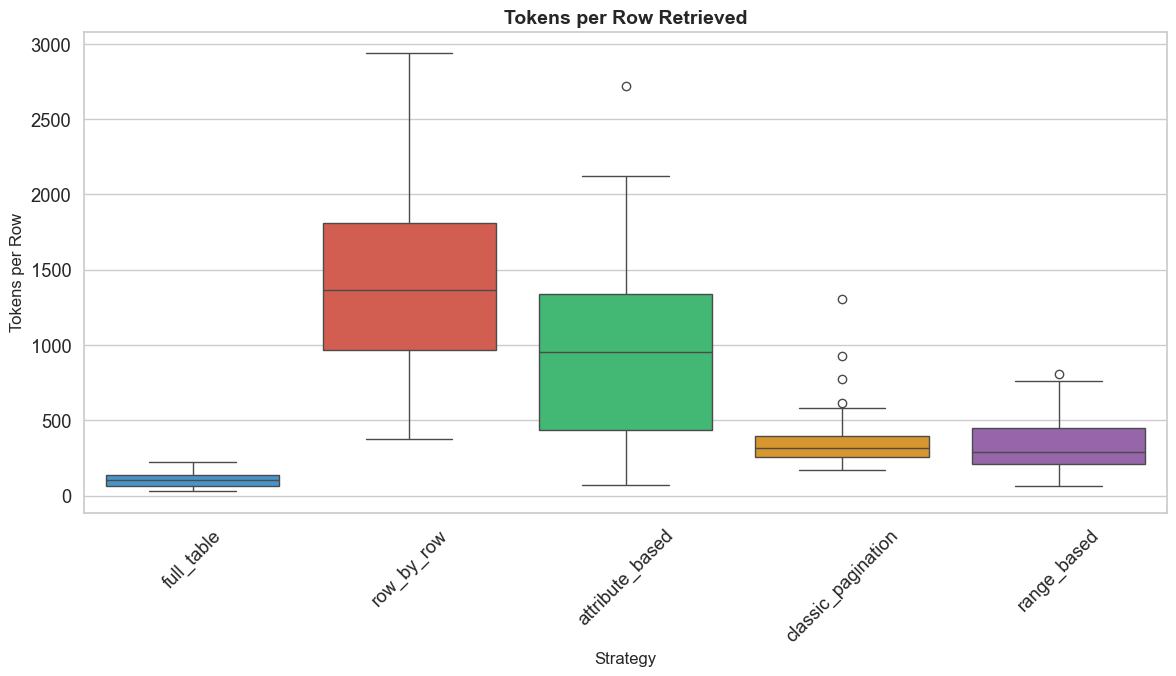

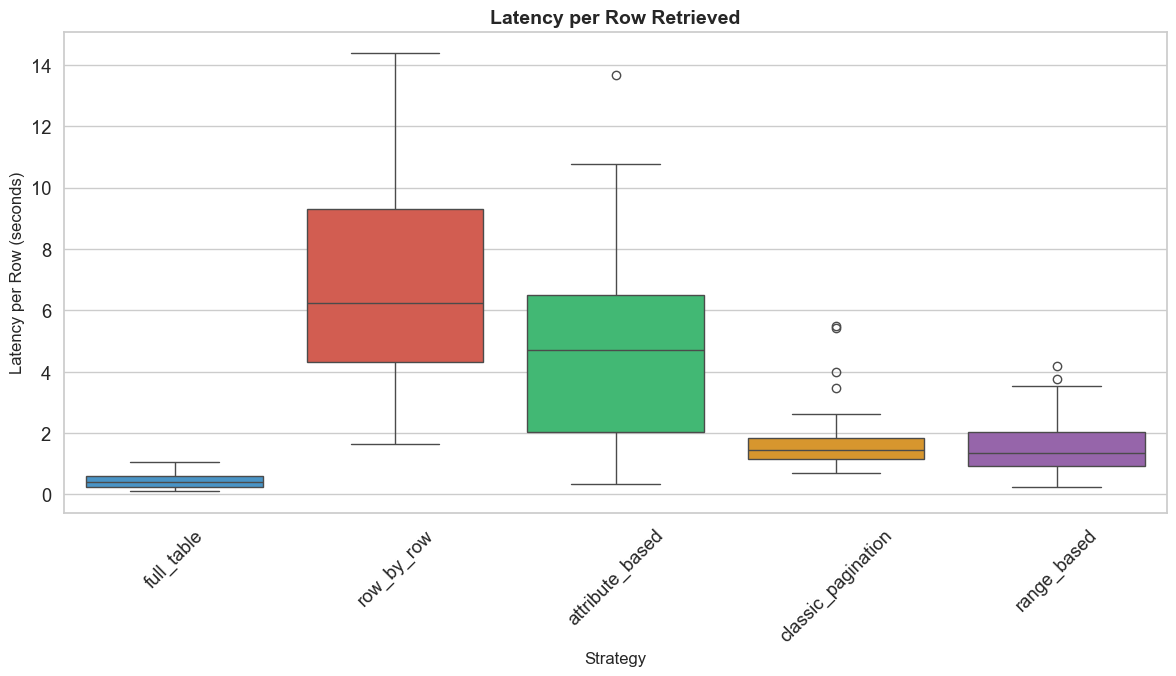

Removed 3 extreme outliers for better visualization


In [341]:
# Efficiency: Tokens and Latency per Row
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Remove extreme outliers using IQR method
def remove_outliers(df, column, factor=3.0):
    """Remove outliers beyond factor * IQR from the quartiles"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Filter data to remove extreme outliers
df_filtered = df_results.copy()
df_filtered = remove_outliers(df_filtered, 'tokens_per_row', factor=3.0)
df_filtered = remove_outliers(df_filtered, 'latency_per_row', factor=3.0)

# Tokens per row
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_filtered, x='strategy', y='tokens_per_row', palette=colors)
plt.title('Tokens per Row Retrieved', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Tokens per Row', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'tokens_per_row_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

# Latency per row
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_filtered, x='strategy', y='latency_per_row', palette=colors)
plt.title('Latency per Row Retrieved', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Latency per Row (seconds)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'latency_per_row_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print how many outliers were removed
n_removed = len(df_results) - len(df_filtered)
print(f"Removed {n_removed} extreme outliers for better visualization")

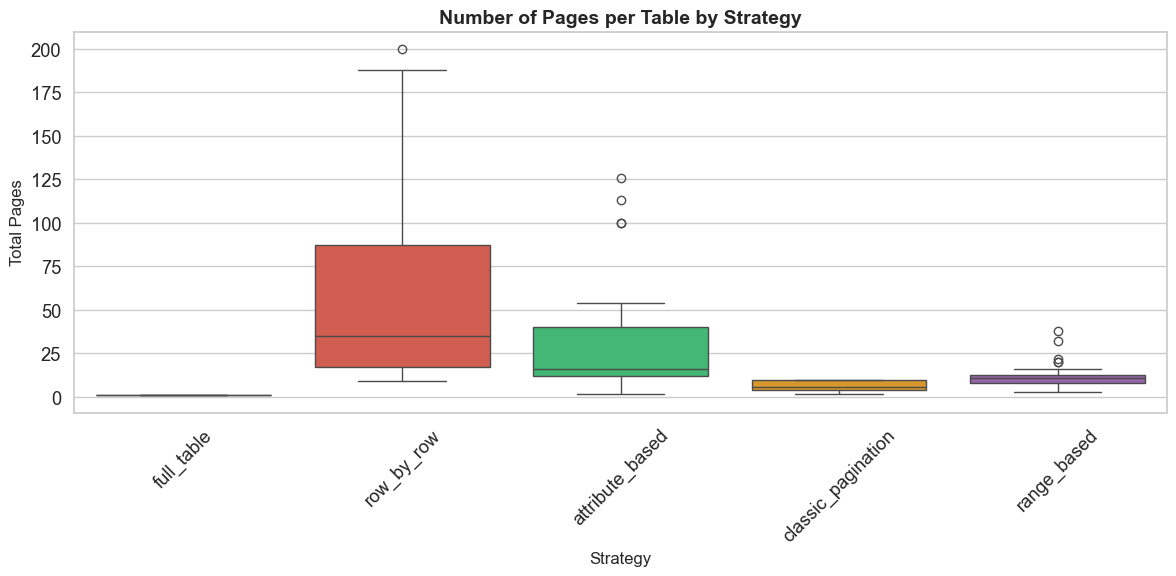

In [306]:
# Pages per Table by Strategy
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, x='strategy', y='total_pages')
plt.title('Number of Pages per Table by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Total Pages', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'pages_per_table.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 4: Quality Metrics

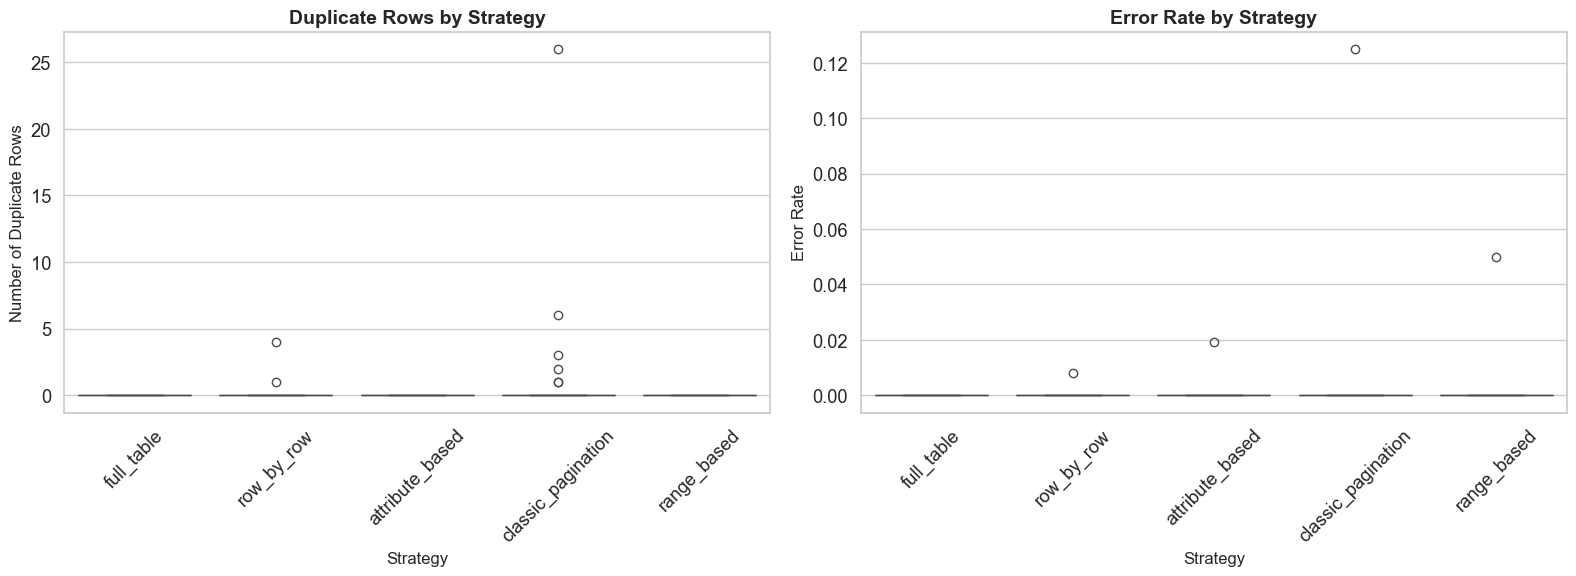

In [307]:
# Quality Metrics: Duplicates and Error Rate
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Duplicate rows
sns.boxplot(data=df_results, x='strategy', y='duplicate_rows', ax=axes[0])
axes[0].set_title('Duplicate Rows by Strategy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Strategy', fontsize=12)
axes[0].set_ylabel('Number of Duplicate Rows', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Error rate
sns.boxplot(data=df_results, x='strategy', y='error_rate', ax=axes[1])
axes[1].set_title('Error Rate by Strategy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Strategy', fontsize=12)
axes[1].set_ylabel('Error Rate', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / 'quality_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

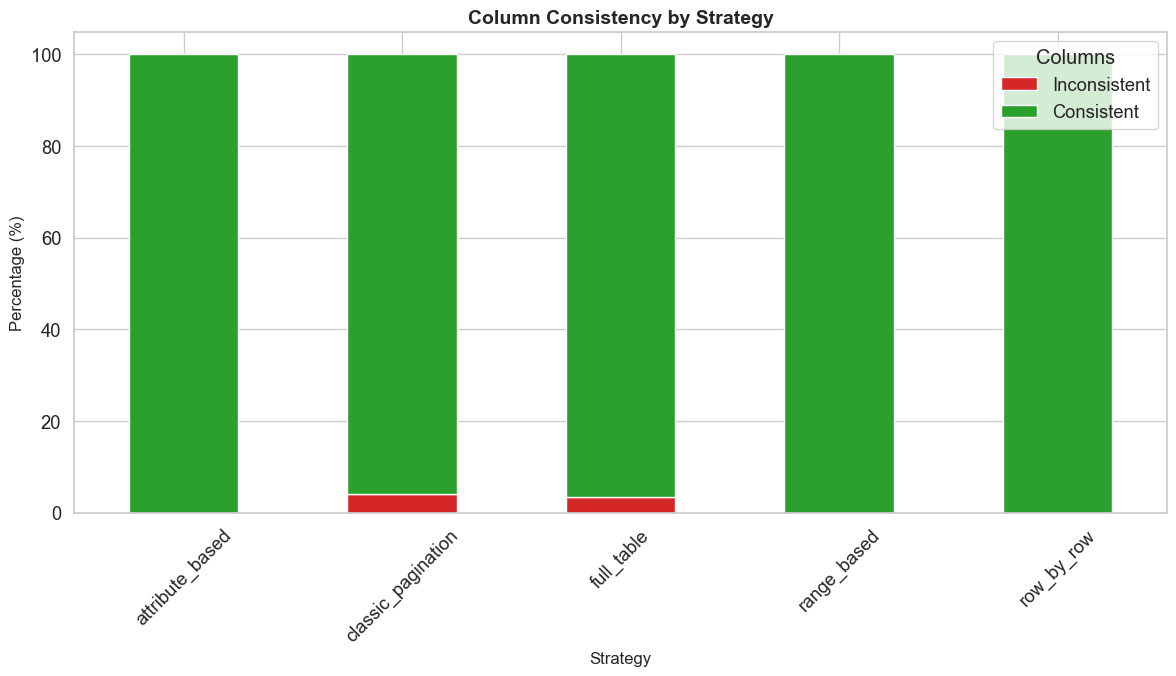

In [308]:
# Column Consistency
consistency_counts = df_results.groupby('strategy')['columns_consistent'].value_counts().unstack(fill_value=0)
consistency_pct = consistency_counts.div(consistency_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
consistency_pct.plot(kind='bar', stacked=True, color=['#d62728', '#2ca02c'])
plt.title('Column Consistency by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(['Inconsistent', 'Consistent'], title='Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'column_consistency.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 5: Trade-off Analysis

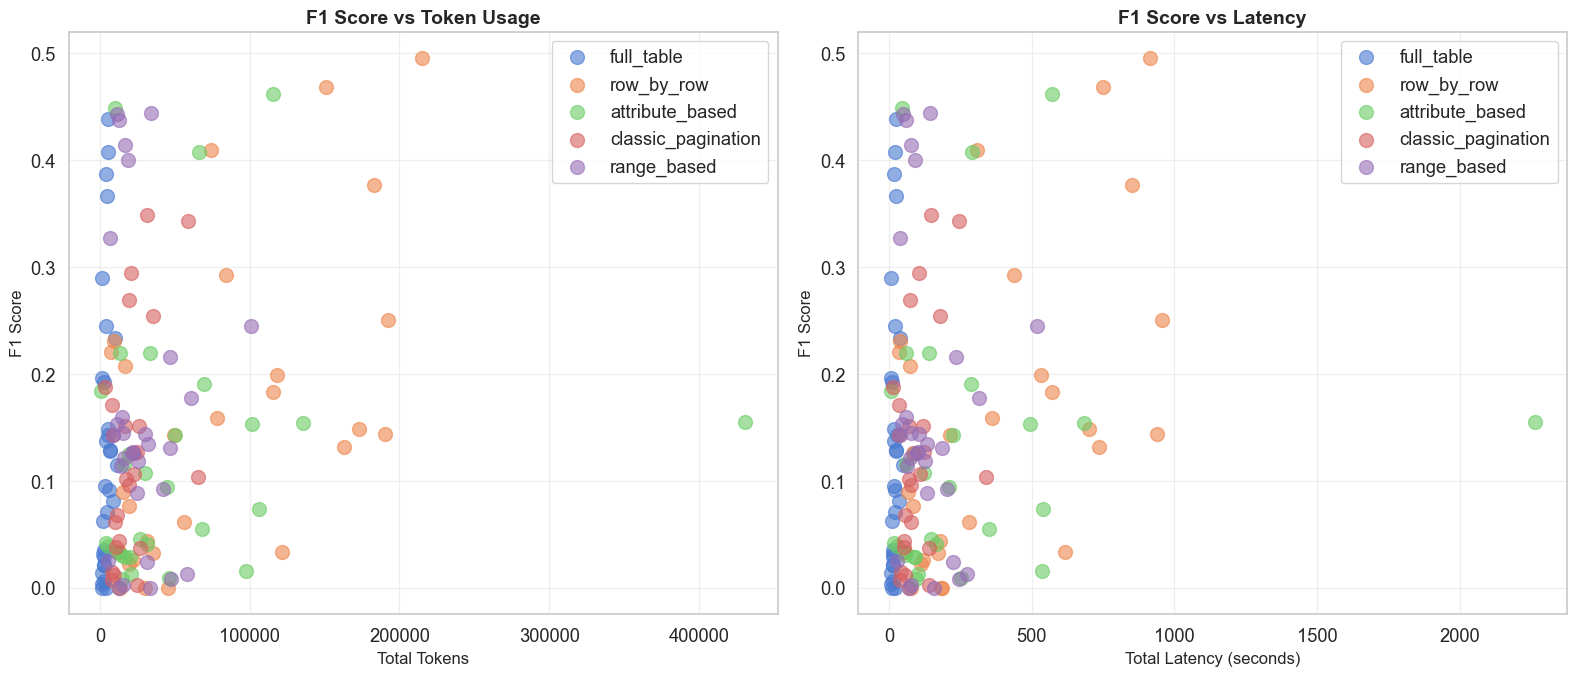

In [309]:
# F1 Score vs Token Usage
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# F1 vs Tokens
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[0].scatter(strategy_data['total_tokens'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[0].set_title('F1 Score vs Token Usage', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Tokens', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 vs Latency
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[1].scatter(strategy_data['total_latency'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[1].set_title('F1 Score vs Latency', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Latency (seconds)', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'tradeoff_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

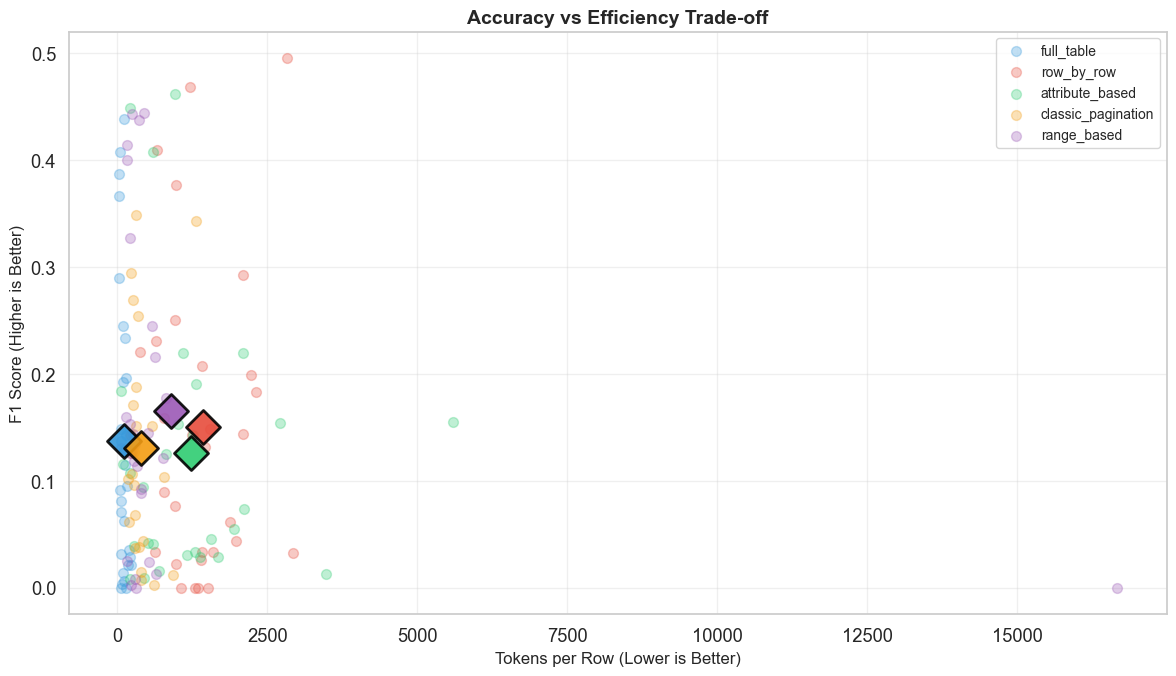

In [342]:
# Pareto Frontier: F1 vs Efficiency (Tokens per Row)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

plt.figure(figsize=(12, 7))

# Plot individual points with lower opacity
for idx, strategy in enumerate(df_results['strategy'].unique()):
    strategy_data = df_results[df_results['strategy'] == strategy]
    plt.scatter(strategy_data['tokens_per_row'], strategy_data['f1_score'], 
               label=strategy, alpha=0.3, s=50, color=colors[idx % len(colors)])
    
    # Plot mean as a larger diamond marker
    mean_tokens = strategy_data['tokens_per_row'].mean()
    mean_f1 = strategy_data['f1_score'].mean()
    plt.scatter(mean_tokens, mean_f1, 
               s=300, marker='D', color=colors[idx % len(colors)], 
               edgecolors='black', linewidths=2, alpha=0.9, zorder=10)

plt.title('Accuracy vs Efficiency Trade-off', fontsize=14, fontweight='bold')
plt.xlabel('Tokens per Row (Lower is Better)', fontsize=12)
plt.ylabel('F1 Score (Higher is Better)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'pareto_frontier.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 6: Table Characteristics Analysis

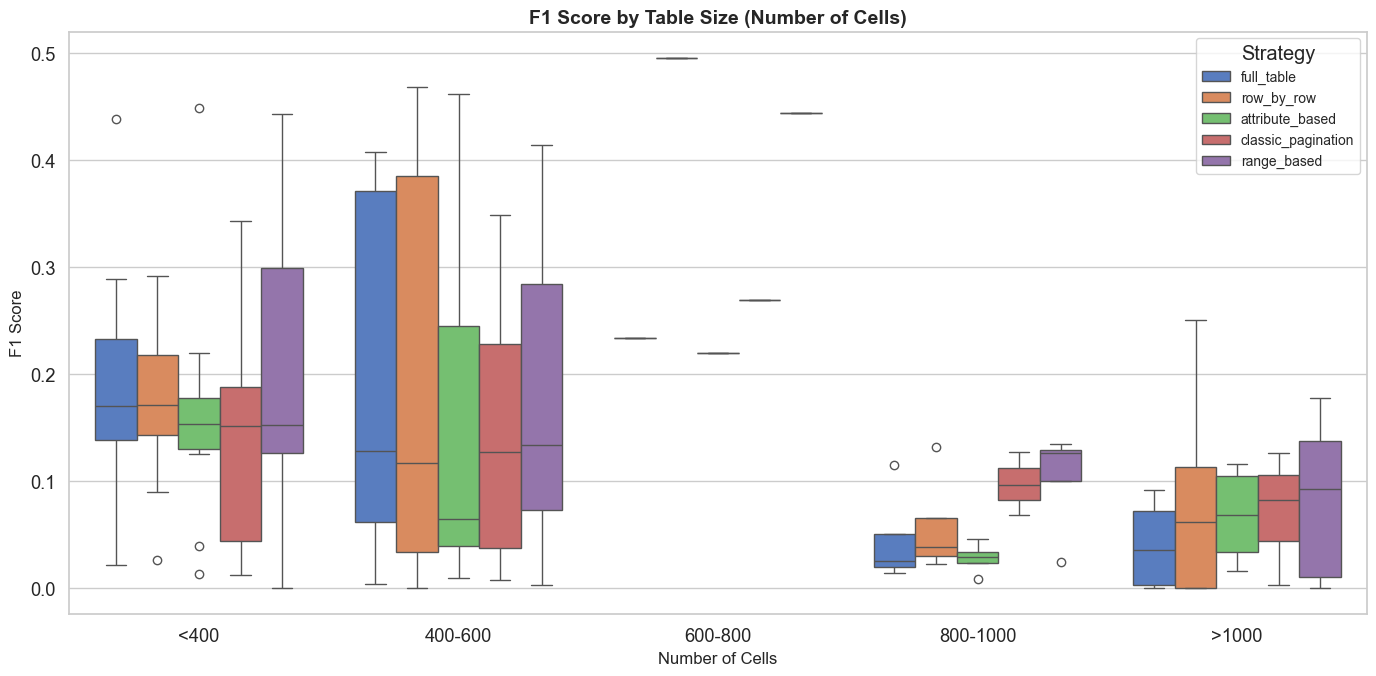

In [345]:
# F1 Score by Table Size (Number of Cells)
# Bin tables by cell count
df_results['cell_bin'] = pd.cut(df_results['num_cells'], 
                                 bins=[0, 400, 600, 800, 1000, float('inf')],
                                 labels=['<400', '400-600', '600-800', '800-1000', '>1000'])

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_results, x='cell_bin', y='f1_score', hue='strategy')
plt.title('F1 Score by Table Size (Number of Cells)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Cells', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(title='Strategy', loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(output_dir / 'f1_by_table_size.png', dpi=300, bbox_inches='tight')
plt.show()

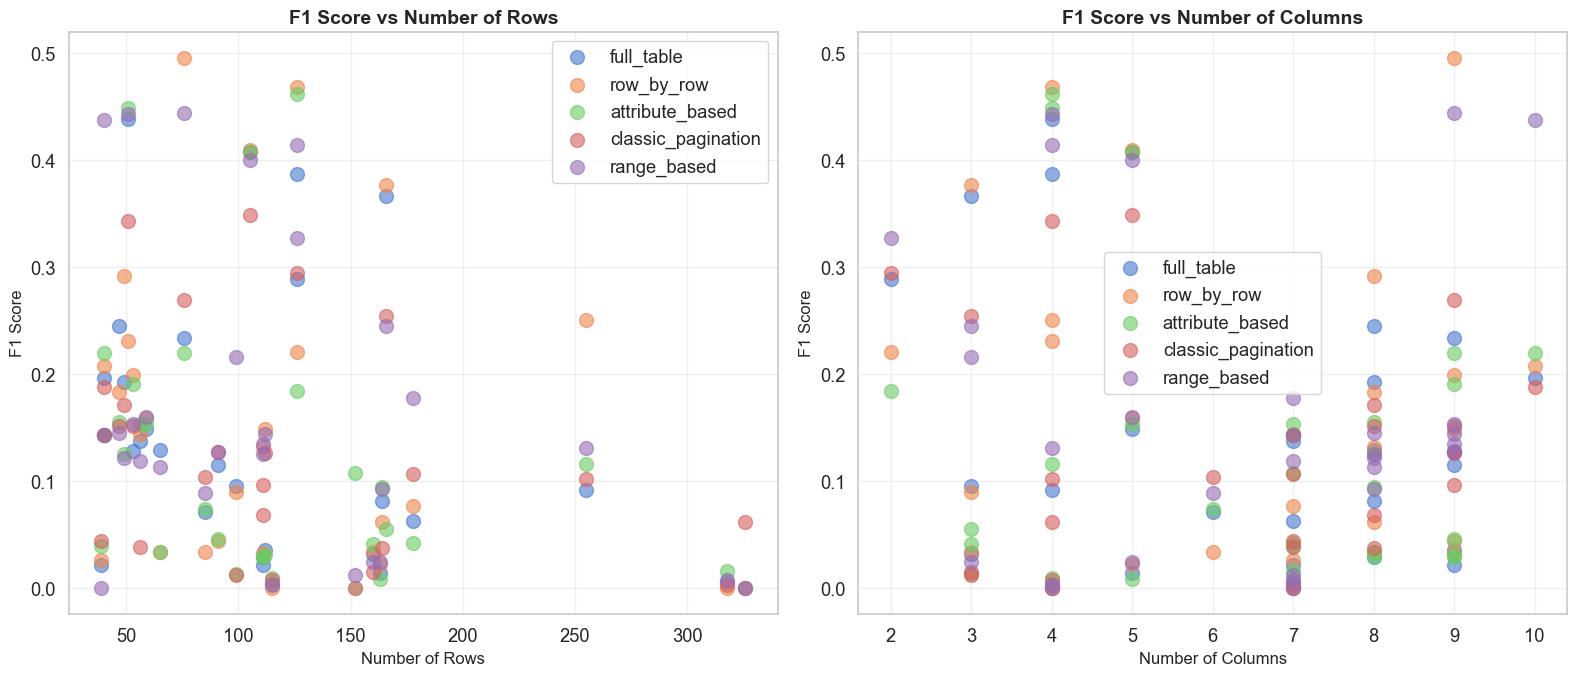

In [346]:
# F1 Score vs Number of Rows and Columns
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# F1 vs Number of Rows
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[0].scatter(strategy_data['num_rows'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[0].set_title('F1 Score vs Number of Rows', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Rows', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 vs Number of Columns
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[1].scatter(strategy_data['num_cols'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[1].set_title('F1 Score vs Number of Columns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Columns', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'f1_by_dimensions.png', dpi=300, bbox_inches='tight')
plt.show()

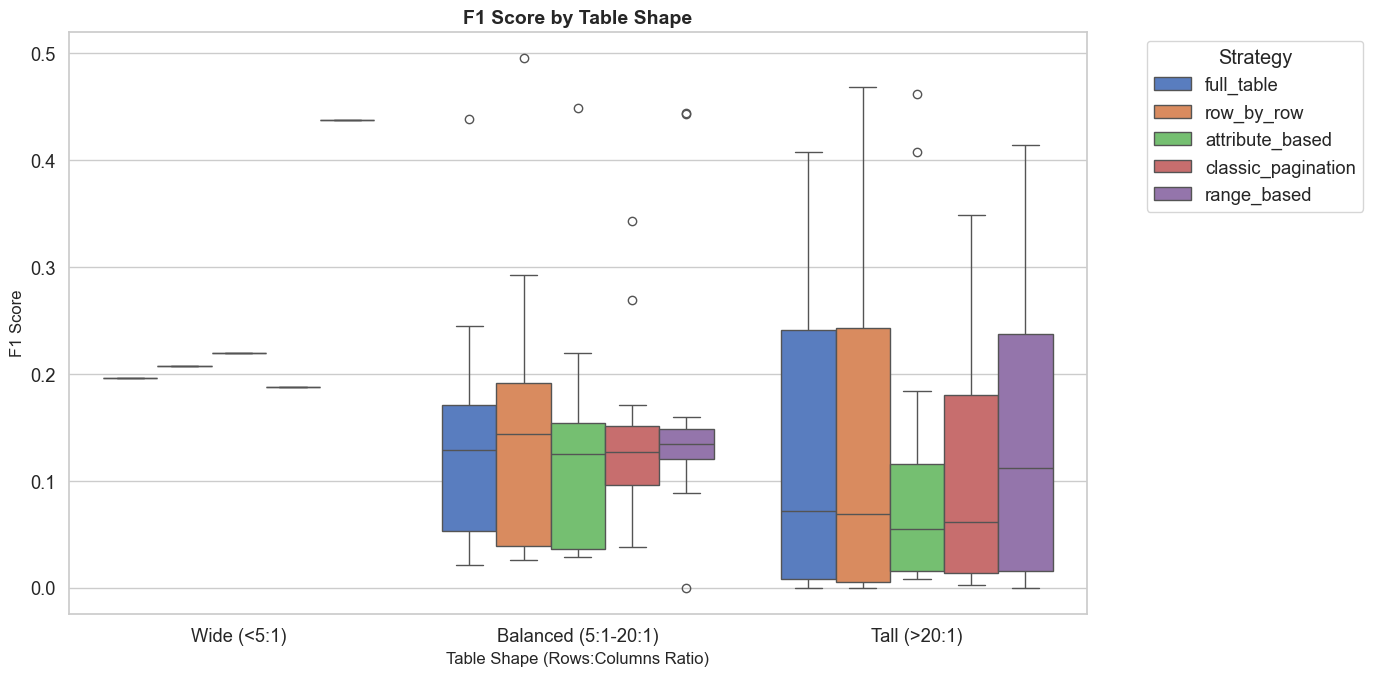

In [313]:
# Table Shape Analysis: Performance on Tall vs Wide Tables
df_results['aspect_ratio'] = df_results['num_rows'] / df_results['num_cols']
df_results['table_shape'] = pd.cut(df_results['aspect_ratio'], 
                                    bins=[0, 5, 20, float('inf')],
                                    labels=['Wide (<5:1)', 'Balanced (5:1-20:1)', 'Tall (>20:1)'])

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_results, x='table_shape', y='f1_score', hue='strategy')
plt.title('F1 Score by Table Shape', fontsize=14, fontweight='bold')
plt.xlabel('Table Shape (Rows:Columns Ratio)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(output_dir / 'f1_by_table_shape.png', dpi=300, bbox_inches='tight')
plt.show()

## Final Summary Report

In [314]:
# Generate comprehensive summary report
print("="*70)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*70)
print(f"\nDataset: {len(df_results['table_id'].unique())} tables")
print(f"Strategies: {len(df_results['strategy'].unique())}")
print(f"Total evaluations: {len(df_results)}")

print("\n" + "="*70)
print("OVERALL PERFORMANCE BY STRATEGY")
print("="*70)

for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    
    print(f"\n{strategy.upper()}:")
    print(f"  F1 Score:        {strategy_data['f1_score'].mean():.4f} ± {strategy_data['f1_score'].std():.4f}")
    print(f"  Keys F1:         {strategy_data['keys_f1'].mean():.4f} ± {strategy_data['keys_f1'].std():.4f}")
    print(f"  Non-Keys F1:     {strategy_data['non_keys_f1'].mean():.4f} ± {strategy_data['non_keys_f1'].std():.4f}")
    print(f"  Avg Tokens:      {strategy_data['total_tokens'].mean():.0f}")
    print(f"  Avg Latency:     {strategy_data['total_latency'].mean():.2f}s")
    print(f"  Tokens/Row:      {strategy_data['tokens_per_row'].mean():.2f}")
    print(f"  Latency/Row:     {strategy_data['latency_per_row'].mean():.3f}s")
    print(f"  Avg Pages:       {strategy_data['total_pages'].mean():.1f}")
    print(f"  Duplicate Rate:  {strategy_data['duplicate_rows'].mean():.2f}")
    print(f"  Error Rate:      {strategy_data['error_rate'].mean():.4f}")

print("\n" + "="*70)
print("BEST PERFORMING STRATEGIES")
print("="*70)

best_f1 = df_results.groupby('strategy')['f1_score'].mean().idxmax()
best_efficiency = df_results.groupby('strategy')['tokens_per_row'].mean().idxmin()
best_speed = df_results.groupby('strategy')['latency_per_row'].mean().idxmin()

print(f"\nHighest F1 Score:     {best_f1}")
print(f"Most Token Efficient: {best_efficiency}")
print(f"Fastest:              {best_speed}")

print("\n" + "="*70)
print(f"All results saved to: {output_dir}")
print("="*70)

COMPREHENSIVE EVALUATION SUMMARY

Dataset: 30 tables
Strategies: 5
Total evaluations: 144

OVERALL PERFORMANCE BY STRATEGY

FULL_TABLE:
  F1 Score:        0.1373 ± 0.1307
  Keys F1:         0.4688 ± 0.3983
  Non-Keys F1:     0.0686 ± 0.0889
  Avg Tokens:      4292
  Avg Latency:     17.50s
  Tokens/Row:      105.80
  Latency/Row:     0.468s
  Avg Pages:       1.0
  Duplicate Rate:  0.00
  Error Rate:      0.0000

ROW_BY_ROW:
  F1 Score:        0.1504 ± 0.1430
  Keys F1:         0.4770 ± 0.4174
  Non-Keys F1:     0.0843 ± 0.1073
  Avg Tokens:      75706
  Avg Latency:     355.01s
  Tokens/Row:      1420.67
  Latency/Row:     6.825s
  Avg Pages:       55.6
  Duplicate Rate:  0.17
  Error Rate:      0.0003

ATTRIBUTE_BASED:
  F1 Score:        0.1256 ± 0.1268
  Keys F1:         0.3876 ± 0.3400
  Non-Keys F1:     0.0684 ± 0.0910
  Avg Tokens:      55926
  Avg Latency:     277.33s
  Tokens/Row:      1234.38
  Latency/Row:     5.980s
  Avg Pages:       33.0
  Duplicate Rate:  0.00
  Error Rat

In [315]:
# Save final summary statistics
final_summary = {
    'timestamp': timestamp,
    'num_tables': len(df_results['table_id'].unique()),
    'num_strategies': len(df_results['strategy'].unique()),
    'total_evaluations': len(df_results),
    'strategy_performance': {},
    'best_strategies': {
        'highest_f1': best_f1,
        'most_efficient': best_efficiency,
        'fastest': best_speed
    }
}

for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    final_summary['strategy_performance'][strategy] = {
        'f1_score_mean': float(strategy_data['f1_score'].mean()),
        'f1_score_std': float(strategy_data['f1_score'].std()),
        'keys_f1_mean': float(strategy_data['keys_f1'].mean()),
        'non_keys_f1_mean': float(strategy_data['non_keys_f1'].mean()),
        'avg_tokens': float(strategy_data['total_tokens'].mean()),
        'avg_latency': float(strategy_data['total_latency'].mean()),
        'tokens_per_row': float(strategy_data['tokens_per_row'].mean()),
        'latency_per_row': float(strategy_data['latency_per_row'].mean())
    }

summary_json_file = output_dir / 'final_summary.json'
with open(summary_json_file, 'w', encoding='utf-8') as f:
    json.dump(final_summary, f, indent=2)

print(f'Saved final summary to {summary_json_file}')

Saved final summary to processing/3_metrics/20251005_091149/final_summary.json
